# Регрессия Лассо
Я всех приветствую! Сегодня я продолжаю изучение методов регуляризации, и поэтому пришло время раскрыть всем, что же такое Регрессия Лассо.
Давайте вспомним, что мы прошли еще в ноябре месяце. 
$$\begin{array}{l}
Y = {\beta _0} + {\beta _1}{x_1} + {\beta _2}{x_2} + {\beta _3}{x_3} + {\beta _4}{x_4} + ... + \varepsilon \\
Y - Переменная \ ответа\\
{x_i} -  Предикторная \ переменная\\
{\beta _i} -  среднее \ влияние \ предикторных \ переменных
\end{array}$$
Здесь ${\beta _i}$ выбираются методом наименьших квадратов. Единственной проблемой здесь может быть сильная корреляция между переменными-предикторами, из-за чего при оценки коэффициентов у нам будет большая дисперсия. А это уже в свою очередь будет значить, что на новых данных построенная модель будет работать хуже, чем может. Поэтому придумали метод Лассо, который пытается свести к минимуму погрешность не самих коэффициентов, а данной величины: $$\begin{array}{l}
RSS\, + \,\lambda \sum {\left| {{\beta _i}} \right|}, \\
где \ RSS = \sum {\left( {{y_i} - {{\hat y}_i}} \right)} 
\end{array}$$
RSS как раз и был наш коэффициент для минимизации погрешностей betta, он называется *сумма квадратов невязок*. В формуле Лассо же фигурирует коэффициент $\lambda$, или же *штраф за усадку*. Когда $\lambda=0$, штрафной член не действует, и регрессия лассо дает те же оценки, что и метод наименьших квадратов. Таким образом, применение Лассо позволяет найти компромисс **смещения и дисперсии**

<p  style="text-align: center;"><img src='https://www.codecamp.ru/content/images/2020/11/lasso1.png' alt="Здесь было фото" width="600"/></p>


In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm # создает нормальное распределение
from sklearn.preprocessing import StandardScaler # Для стандартизации данных по величине относительно средней величине на обученных данных.
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet #Регрессионные методы вставляем мы
from scipy.stats import skew #Вычисляет у данных величину асимметрии. У нормально распределенных данных асимметрия будет приближаться к нулю


%matplotlib inline
pd.set_option('display.max_columns', 500)
'''
display.max_columns : int
    Если значение max_cols превышено, переключитесь в режим усечения. В зависимости от
    `large_repr`, объекты либо усекаются по центру, либо печатаются в виде
    сводного представления. Значение "Нет" означает неограниченное.
'''

'\ndisplay.max_columns : int\n    Если значение max_cols превышено, переключитесь в режим усечения. В зависимости от\n    `large_repr`, объекты либо усекаются по центру, либо печатаются в виде\n    сводного представления. Значение "Нет" означает неограниченное.\n'

## Датасет
Для подробного анализа датасета можете перейти по ссылке *https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques*
Я не буду переводить все переменные, потому что там из 79 разных штук, но просто немного расскажу о данных.
Нам нужно научить машину по подробным данных о домах научиться предугадывать цену дома. Причем из-за 79 различных параметров, можно найти для каждого человека идеальный дом, и оценить стоимость его идеи. 

In [167]:
#Импорт данных
df_train=pd.read_csv('train.csv', index_col='Id')
df_test=pd.read_csv('test.csv', index_col='Id')
y_train=df_train.SalePrice #Как и в прошлый раз, мы отделяем от датасета данные о ценах на дома.
df_train.drop(columns='SalePrice', inplace=True) #  inplace=True работает не с копией, а именно с оригиналом ДФ (датафрейма)
print(df_train.columns)
print(f"Всего столбцов:{len(df_train.columns)}")
print(f"Всего численных столбцов: {len(df_train._get_numeric_data().columns)}") #_get_numeric_data() возвращает только численные столбцы
print(f"Всего object(словесных) столбцов: {len(df_train.select_dtypes(include='object').columns)}")

print('--------------------------------')
print('Давайте разберемся заодно, как работает select_dtypes(include)')
print(len(df_train.select_dtypes(include='object').columns))
print(len(df_train.select_dtypes(include='int32').columns))
print(len(df_train.select_dtypes(include='int64').columns))
print(f"То есть можно туда впихнуть все типы данных, к примеру:\nnumerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']")

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Пропущенные данные
Угадайте, что мы просто обязаны сделать сразу после того, как получили данные? Верно, проверить их правильность! Но сначала мы должны узнать, а все ли данные на месте, может есть какие-то пропуски?
Lets explain!
Здесь цель состоит в том, чтобы обнаружить и обработать недостающие значения в наших данных, важно проверить описание набора данных. Ниже приведены некоторые выводы:
* Категориальные NAN не являются пропущенными значениями, они просто означают, что у дома нет этой конкретной функции, это означает, что они являются дополнительной категорией. По этой причине они были заменены категорией "Нет".
* Числовые значения NAN действительно являются недостающими значениями и были рассчитаны с использованием среднего значения этого конкретного признака.
* Конкретный случай был с фасадом участка, вместо того, чтобы вменять среднее значение объекта, я вменял, используя среднее значение соответствующей окрестности.

    MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                        
1        False     False        False    False   False   True     False   
2        False     False        False    False   False   True     False   
3        False     False        False    False   False   True     False   
4        False     False        False    False   False   True     False   
5        False     False        False    False   False   True     False   

    LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
Id                                                                           
1         False      False      False      False         False       False   
2         False      False      False      False         False       False   
3         False      False      False      False         False       False   
4         False      False      False      False         False       False   
5     

Text(0.5, 1.0, 'Столбцы с нулевыми строками')

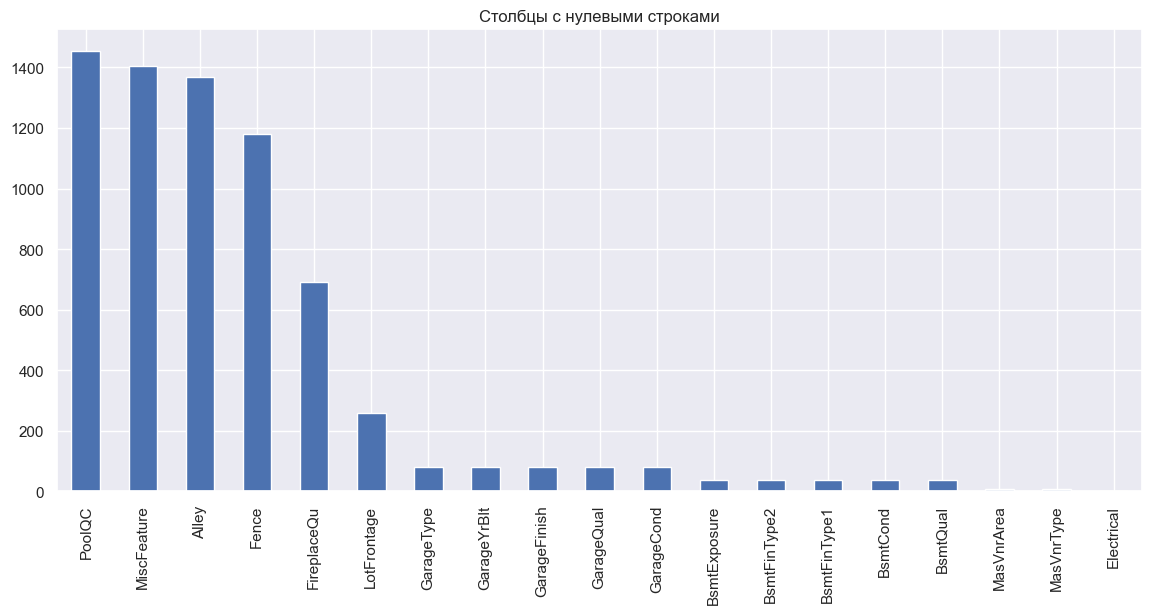

In [168]:
axes = plt.subplots(figsize=(14, 6))
missing= df_train.isnull() #bool операция по нахождению пропущенных значений в строках
print(missing.head(5))
missing=missing.sum()
missing=missing[missing>0]
missing.sort_values(inplace=True, ascending=False) #ascending=False ставит их в порядке убывания
missing.plot.bar()
plt.title('Столбцы с нулевыми строками')

In [169]:
categorical_features = df_train.select_dtypes(include='object').columns
df_train[categorical_features] = df_train[categorical_features].fillna('None')
df_test[categorical_features] = df_test[categorical_features].fillna('None')

    MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                        
1        False     False        False    False   False  False     False   
2        False     False        False    False   False  False     False   
3        False     False        False    False   False  False     False   
4        False     False        False    False   False  False     False   
5        False     False        False    False   False  False     False   

    LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
Id                                                                           
1         False      False      False      False         False       False   
2         False      False      False      False         False       False   
3         False      False      False      False         False       False   
4         False      False      False      False         False       False   
5     

Text(0.5, 1.0, 'Столбцы с нулевыми строками')

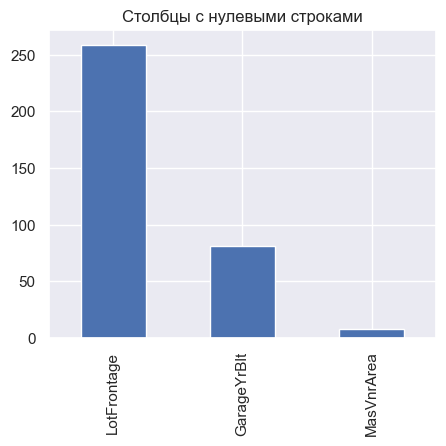

In [170]:
axes = plt.subplots(figsize=(5, 4))
missing= df_train.isnull() #bool операция по нахождению пропущенных значений в строках
print(missing.head(5))
missing=missing.sum()
missing=missing[missing>0]
missing.sort_values(inplace=True, ascending=False) #ascending=False ставит их в порядке убывания
missing.plot.bar()
plt.title('Столбцы с нулевыми строками')

Как видите, мы избавились почти от всех нулевых столбцов. Но, подождите, а что тогда эти 3 тут забыли? Дело в том, что мы заменили NaN значения только для тех столбцов, которые содержат словесные данные, а не численные. И, как оказалось, есть 3 численных столбца, которые также требуют действий. 

**Что же нам делать?**

Либо мы удалим эти строки, либо мы туда что-то будем вставлять. Но так как там числа, просто поставить нули мы тоже не может. На самом деле, для такой вещи есть конкретное решение.

Нужно Поставить туда просто средние значения о столбцов! Таким образом средняя величина всего столбца никак не изменится, и все рады! Но как это сделать быстро? Сейчас покажу.

In [171]:
for title in missing.keys():
    df_train[title]=df_train[title].transform(lambda x: x.fillna(x.median()))
    print(df_train.isnull().sum()[title])

missing= df_test.isnull() #bool операция по нахождению пропущенных значений в строках
missing=missing.sum()
missing=missing[missing>0]
for title in missing.keys():
    df_test[title]=df_test[title].transform(lambda x: x.fillna(x.median()))
    print(df_test.isnull().sum()[title])

0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [172]:
idx_split = df_train.shape[0]
df_train = df_train.append(df_test)
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
non_ordinal_features = ['LandSlope','Utilities','MSZoning', 'Street','Alley','LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','MasVnrType','Foundation', 'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Heating', 'CentralAir', 'Electrical','Functional', 'GarageType','GarageFinish','PavedDrive', 'Fence','MiscFeature','SaleType','SaleCondition', "MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)
dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True) #для кодировки non_ordinal_features данных в числа 
df_train = pd.concat([df_train,dummies], axis=1) # объединим с дф переделанные данные
df_train = df_train.drop(non_ordinal_features,axis=1) # а старые удалим





C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\1192069268.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_test)


In [173]:
def cat_to_num(x):
    if x=='Ex':
        return 5
    if x=='Gd':
        return 4
    if x=='TA':
        return 3
    if x=='Fa':
        return 2
    if x=='Po':
        return 1
    if x=='None':
        return 0

df_train.loc[:,ordinal_features] = df_train.loc[:,ordinal_features].applymap(cat_to_num) #applymap поэлементно выполняет функцию которую внутри нее указали

C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\2525837929.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.loc[:,ordinal_features] = df_train.loc[:,ordinal_features].applymap(cat_to_num) #applymap поэлементно выполняет функцию которую внутри нее указали


In [174]:
X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]

In [175]:
X = X.assign(SalePrice=y_train)

Text(0.5, 1.0, 'Распределение цен на дома')

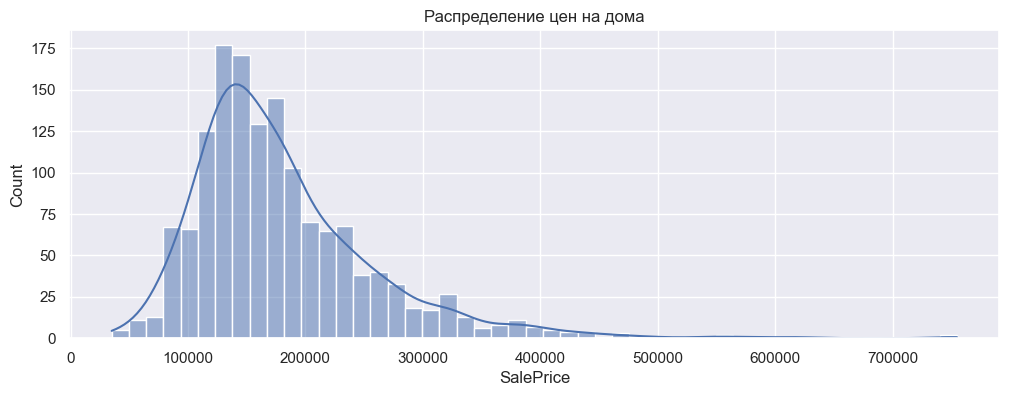

In [176]:
sns.set() # указываем, что все параметры выбираются по умолчанию (в том числе тема)
axes = plt.subplots(figsize=(12, 4)) #если не указывать, программа будет работать, но размеры графиков будут вычисляться автоматически. сделаем на наш вкус
sns.histplot(X.SalePrice, kde=True).set_title('Распределение цен на дома') # density я решил не использовать тк частота повторений малая, и не дает никакой информации
#sns.histplot(X.SalePrice, kde=True, stat='density')

Как видите, распределение по стоимости домов смещена вправо. Это связано с тем, что минимальная цена на дом будет ограничена (тк есть минимальная цена на материалы, качество дома), а ограничений на максимальную стоимость попросту не существует.
Дальше корреляция.
Существуют сильно коррелированные функции друг с другом, это может привести к мультиколлинеарности на этапе моделирования, это наиболее проблемные функции:
* Garage Cars and GarageArea are highly correlated.
* PoolQC and PoolArea are highly correlated.
* Fireplaces and FireplaceQu are highly correlated.
* GarageCond and GarageCond are highly correlated

<AxesSubplot: >

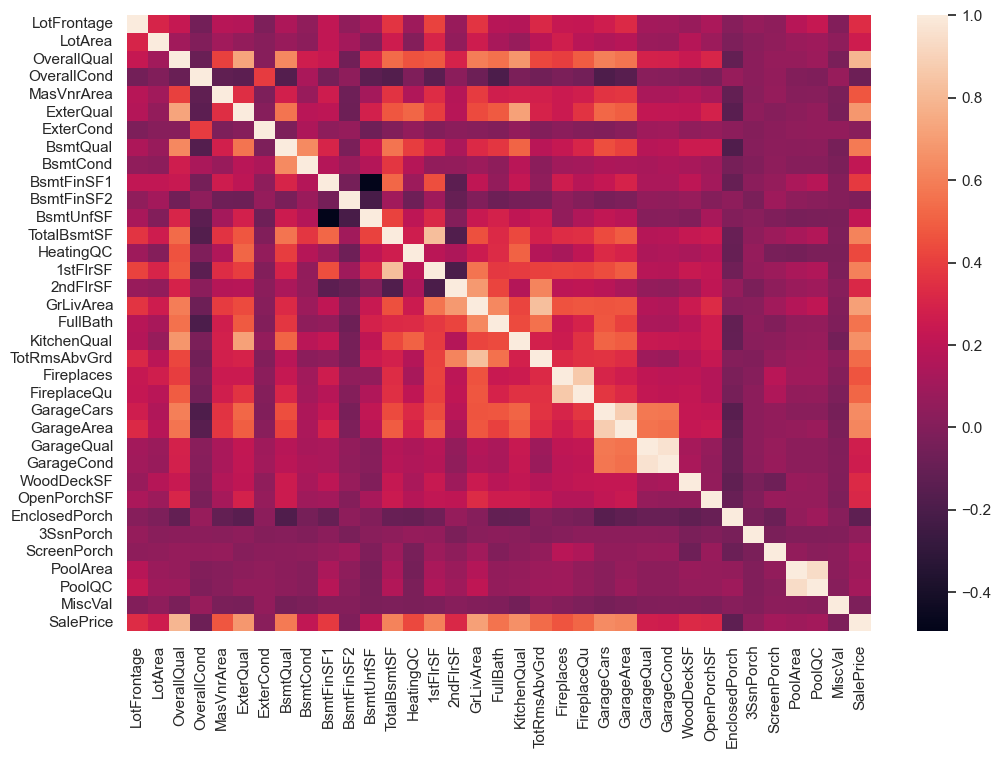

In [177]:
ax=plt.subplots(figsize=(12,8))
corr_matrix=X.drop(dummies,axis=1).corr()
sns.heatmap(corr_matrix)

(1460, 11) (11, 1460)
['SalePrice' 'OverallQual' 'GrLivArea' 'ExterQual' 'KitchenQual'
 'GarageCars' 'GarageArea' 'TotalBsmtSF' '1stFlrSF' 'BsmtQual' 'FullBath']
[[1.         0.7909816  0.70862448 0.68263924 0.65959972 0.6404092
  0.62343144 0.61358055 0.60585218 0.5852072  0.56066376]
 [0.7909816  1.         0.59300743 0.72627849 0.67333078 0.60067072
  0.56202176 0.5378085  0.47622383 0.62937911 0.55059971]
 [0.70862448 0.59300743 1.         0.43598606 0.42056275 0.46724742
  0.46899748 0.4548682  0.56602397 0.32795563 0.63001165]
 [0.68263924 0.72627849 0.43598606 1.         0.7161222  0.52639018
  0.49577762 0.47057956 0.39783537 0.56555809 0.48394942]
 [0.65959972 0.67333078 0.42056275 0.7161222  1.         0.50980961
  0.48960558 0.43262962 0.38702729 0.51093804 0.43464802]
 [0.6404092  0.60067072 0.46724742 0.52639018 0.50980961 1.
  0.88247541 0.43458483 0.43931681 0.44919444 0.46967204]
 [0.62343144 0.56202176 0.46899748 0.49577762 0.48960558 0.88247541
  1.         0.48666546

Text(0.5, 1.0, 'Карта зависимостей переменных')

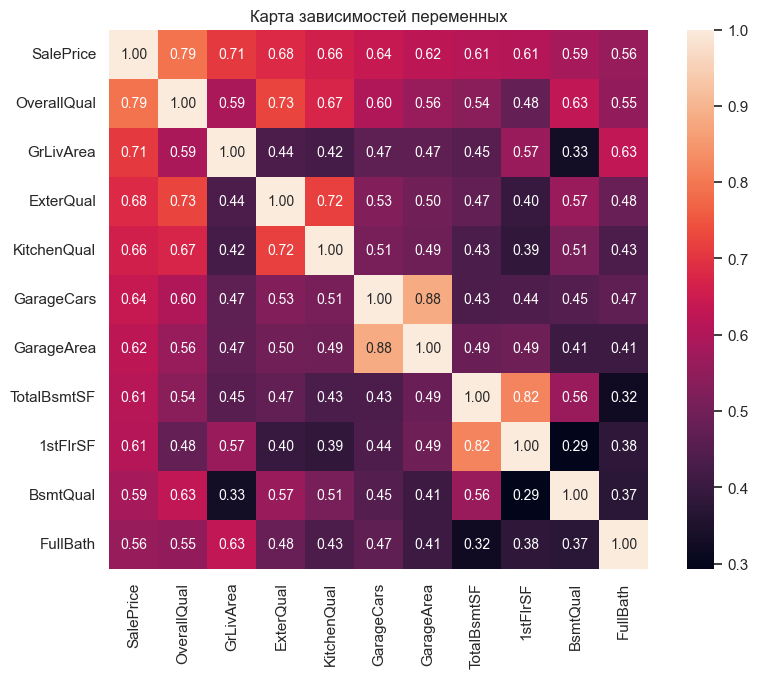

In [178]:
#print(corr_matrix)
ax = plt.subplots(ncols=1, figsize=(10,7))
cols = corr_matrix.nlargest(11, 'SalePrice').index
print(X[cols].shape,X[cols].T.shape) # Смотрим на транспонированную матрицу тк у нас всего 11 столбцов должно быть, а не 1460
print(cols.values) # Список с названиями столбцов
cm = np.corrcoef(X[cols].T) # отдельно посчитаем корреляционные коэффициенты
print(cm)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values).set_title('Карта зависимостей переменных')
#cbar=False - Можно добавить чтобы не рисовать цветовой бар сбоку
#annot_kws = позволяет изменять параметры аннотаций в каждой клетке. Размер, шрифт, цвет...
#xticklabels и y были добавлены тк судя по print(cm), данная переменная содержит только значения коэффициентов, без названий столбцов. Поэтому, чтобы heatmap не считал самостоятельно эти значения как он хочет. мы вставили уже вместо него всё, в том числе и название столбцов
#fmt='.2f' - точность отображения аннотаций в клетках

Вот представлены топ 10 параметров, которые сильнее всего коррелируют на цену дома. Очевидно, что лучше не использовать те параметры, которые сильно коррелируют друг с другом, потому что таким образом машина будет работать менее точно из-за учета этой корреляции. 

Теперь числовые переменные:
Цель здесь состоит в том, чтобы нанести на график числовые характеристики, чтобы понять их распределение, и есть ли у них выбросы. Ниже приведены некоторые из достигнутых выводов:
* В большинстве числовых объектов есть некоторые отклонения, на самом деле это одни и те же точки для всех объектов. Это действительно нежелательные выбросы, как видно из описания набора данных, поэтому они будут удалены.
* Есть несколько искаженных распределений, так что нам, возможно, придется позаботиться и об этом.

По графику видно, что есть очевидные выбросы, с которыми нужно будет что-то сделать


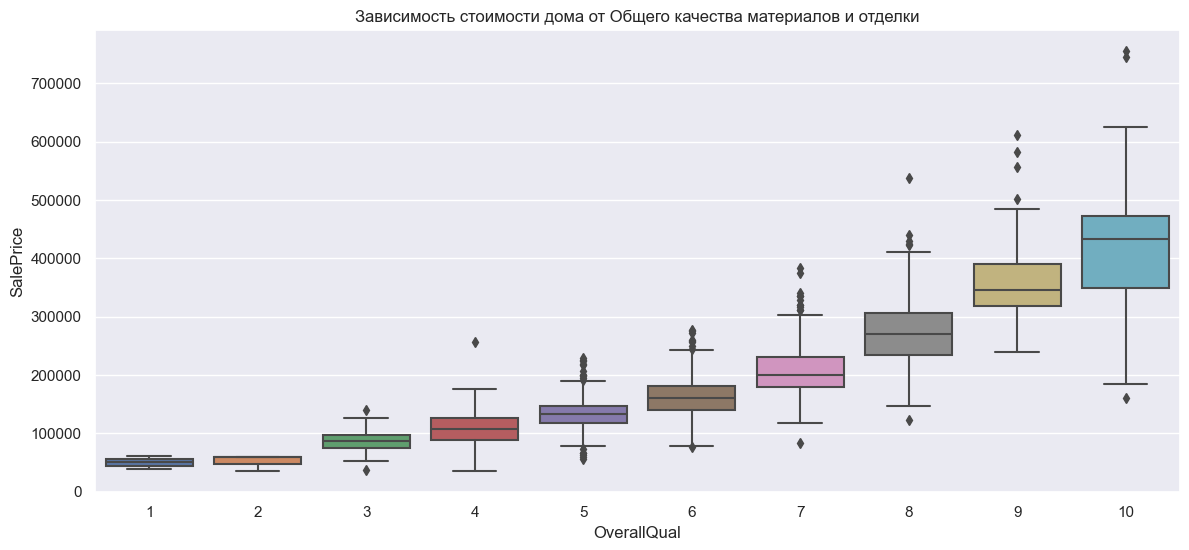

In [179]:
axes = plt.subplots(figsize=(14, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=X).set_title('Зависимость стоимости дома от Общего качества материалов и отделки')
print('По графику видно, что есть очевидные выбросы, с которыми нужно будет что-то сделать')

Text(0.5, 0.98, 'Зависимость стоимости дома от размера цокольного этажа (в дюймах)')

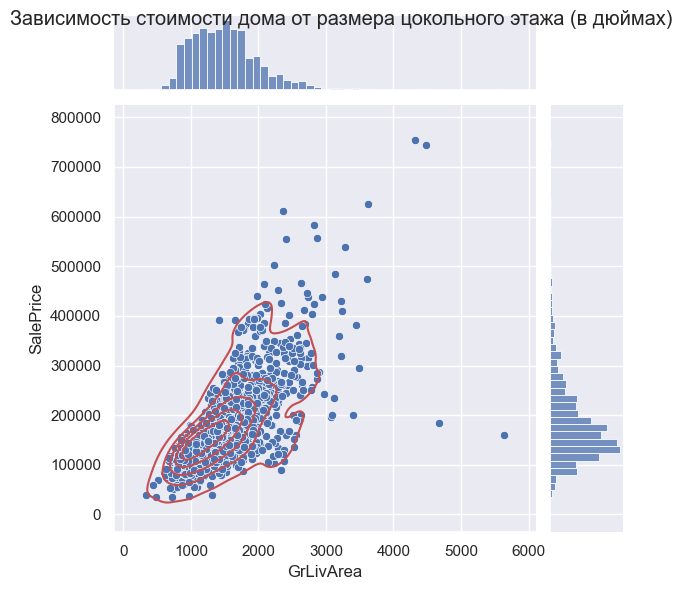

In [180]:
# sns.set()
g=sns.jointplot(kind='scatter',data=X, x='GrLivArea', y='SalePrice')
g.plot_joint(sns.kdeplot, color="r", levels=6).fig.suptitle("Зависимость стоимости дома от размера цокольного этажа (в дюймах)")
# написал через fig.suptitle тк просто title здесь не применяется хз почему
#также я вписал график в g переменную, ее можно вызвать в любой момент чтобы легче было опираться на график в больших прогах

Text(0.5, 0.98, 'Зависимость стоимости дома от Общая площадь подвала в квадратных футах')

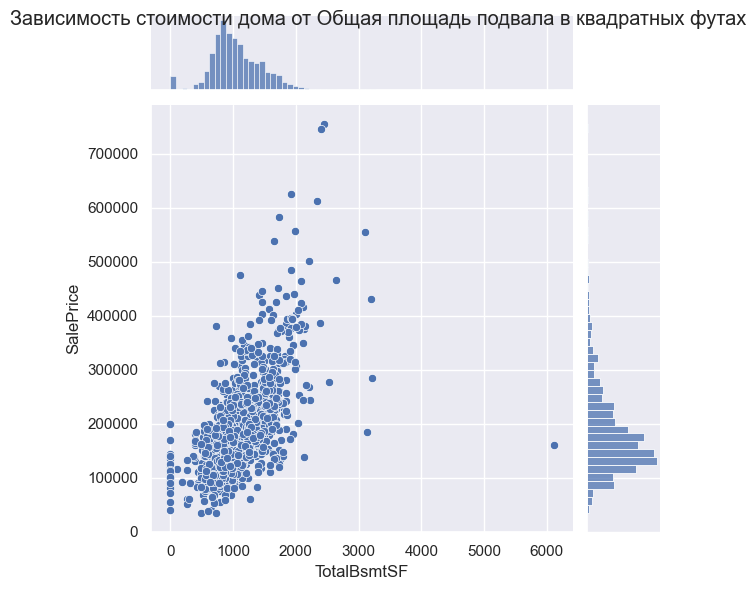

In [181]:
sns.jointplot(kind='scatter',data=X, x='TotalBsmtSF', y='SalePrice').fig.suptitle("Зависимость стоимости дома от Общая площадь подвала в квадратных футах")

Text(0.5, 0.98, 'Зависимость стоимости дома от Площади первого этажа в футах')

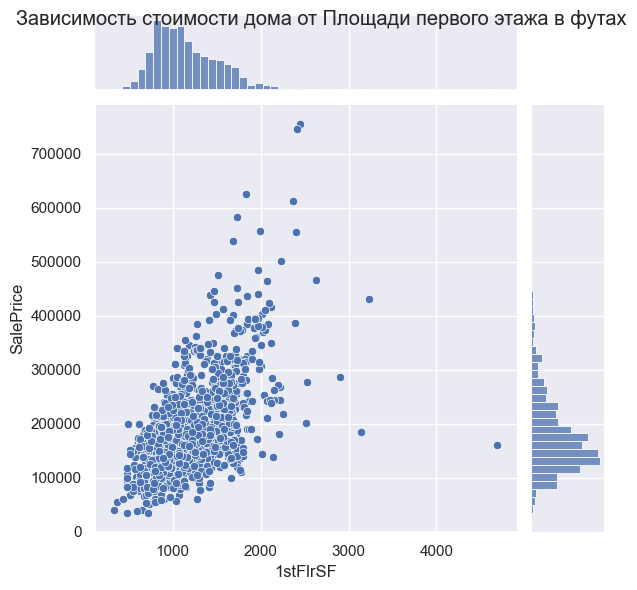

In [182]:
sns.jointplot(kind='scatter',data=X, x='1stFlrSF', y='SalePrice').fig.suptitle("Зависимость стоимости дома от Площади первого этажа в футах")

## Начало моделирования
Ну что ж, мы посмотрели на графики, и увидел даже, что есть небольшие выбросы, связанные либо с неучтенными данными, либо с расположением особым, либо просто с завышенными ценами на дома.

Вообще, эта программа в идеале может использовать в качестве функционала по автоматическому подсчету реальной цены дома. Осталось только переехать из России, и тогда программа будет работать нормально потому что тут много двухэтажных домов с подвалами и со всем что только можно. Ладно, погнали разбивать данные обратно.


In [183]:
X.drop(columns='SalePrice', inplace=True)

In [184]:
#Создадим новые столбцы для более качественного анализа
X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
X["TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
X["GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]

X_test["TotalHouse"] = X_test["TotalBsmtSF"] + X_test["1stFlrSF"] + X_test["2ndFlrSF"]   
X_test["TotalHouse_OverallQual"] = X_test["TotalHouse"] * X_test["OverallQual"]
X_test["GrLivArea_OverallQual"] = X_test["GrLivArea"] * X_test["OverallQual"]

C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\3668275739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["TotalHouse"] = X_test["TotalBsmtSF"] + X_test["1stFlrSF"] + X_test["2ndFlrSF"]
C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\3668275739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["TotalHouse_OverallQual"] = X_test["TotalHouse"] * X_test["OverallQual"]
C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\3668275739.py:8: SettingWithCopyWarning: 
A value is trying to be set

In [185]:
print(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
X = X.drop(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
y_train = y_train.drop([524, 1299])

Int64Index([524, 1299], dtype='int64', name='Id')


In [186]:
numeric_feats = X.dtypes[X.dtypes != "object"].index
numeric_feats = numeric_feats.drop(dummies)
numeric_feats = numeric_feats.drop(ordinal_features)
print(numeric_feats)
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(f'Таблица симметрий:\n{skewness}')
skewness = skewness[abs(skewness) > 0.75]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'TotalHouse', 'TotalHouse_OverallQual', 'GrLivArea_OverallQual'],
      dtype='object')
Таблица симметрий:
                             Skew
MiscVal                 24.434913
PoolArea                15.932532
LotArea                 12.560986
3SsnPorch               10.286510
BsmtFinSF2               4.247550
ScreenPorch              4.114690
EnclosedPorch            3.083987
MasVnrArea               2.693554
OpenPorchSF              2.337421
LotFrontage              1.719086
WoodDeckSF               1.544214
GrLivArea_OverallQual    1.492289
TotalHouse_OverallQual   1.391617
GrLivArea                1.009951
BsmtUnfSF  

Как мы уже знаем, наши значения имеют смещенные параметры. Если мы хотим получить нормальное распределение, то мы должны найти параметры, которые сильнее всего влияют на это распределение.
После этого мы их преобразуем, и будем работать уже с этими результатами для обучения модели на более точных параметрах.

In [187]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam)
    X_test[feat] = boxcox1p(X_test[feat], lam)

C:\Users\enoki\AppData\Local\Temp\ipykernel_10776\1004080227.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feat] = boxcox1p(X_test[feat], lam)


In [188]:
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(f'Таблица симметрий:\n{skewness}')
skewness = skewness[abs(skewness) > 0.75]

Таблица симметрий:
                             Skew
PoolArea                15.515751
3SsnPorch                7.822202
MiscVal                  5.501393
ScreenPorch              3.181641
BsmtFinSF2               2.616835
EnclosedPorch            2.158639
LotArea                  0.710724
MasVnrArea               0.606190
2ndFlrSF                 0.313502
Fireplaces               0.225902
WoodDeckSF               0.219614
1stFlrSF                 0.139021
OpenPorchSF              0.114551
GrLivArea                0.082854
TotRmsAbvGrd             0.041494
GrLivArea_OverallQual   -0.043549
OverallCond             -0.069633
TotalHouse_OverallQual  -0.174854
TotalHouse              -0.246186
FullBath                -0.315420
OverallQual             -0.446390
BsmtFinSF1              -0.500361
LotFrontage             -0.656579
GarageCars              -1.204495
BsmtUnfSF               -1.553057
GarageArea              -3.040319
TotalBsmtSF             -4.161816


In [189]:
y_train = np.log(y_train)

In [190]:
#Избегание мультиколлинеарности (убираем столбцы которые можно заменить коррелирующие им)
multicol_features = ['GarageCars', 'PoolQC', 'FireplaceQu', 'GarageCond']
X = X.drop(multicol_features, axis = 1)
X_test = X_test.drop(multicol_features, axis = 1)

In [191]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X[X.columns] = scaler.transform(X[X.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [192]:
print(X)

      LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  ExterQual  \
Id                                                                             
1        0.365634  0.281320     0.793272     0.656098    0.597109   0.666667   
2        0.440709  0.303531     0.709484     0.926895    0.000000   0.333333   
3        0.381734  0.331740     0.793272     0.656098    0.566540   0.666667   
4        0.337362  0.302614     0.793272     0.656098    0.000000   0.333333   
5        0.458718  0.375179     0.868584     0.656098    0.695850   0.666667   
...           ...       ...          ...          ...         ...        ...   
1456     0.348899  0.270142     0.709484     0.656098    0.000000   0.333333   
1457     0.463107  0.360507     0.709484     0.757115    0.518925   0.333333   
1458     0.371068  0.293054     0.793272     1.000000    0.000000   1.000000   
1459     0.381734  0.305662     0.614823     0.757115    0.000000   0.333333   
1460     0.417104  0.309611     0.614823

In [193]:
#Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

rgr_ls = Lasso(fit_intercept = True)
param_grid = {
    "alpha": [0.0002, 0.0003, 0.0005, 0.0008, 0.001] #Рассмотрим Lasso метод для нескольких значений параметра Лямбда (тут это альфа)
}
searchCV = GridSearchCV(rgr_ls, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
searchCV.fit(X, y_train)
np.sqrt(searchCV.best_score_*-1)



0.11741011649397863

## GridSearchCV
Что это вообще такое?
Это функция, которая позволяет определить наилучшие значения гиперпараметров любой модели простым перебором, или случайными выборками.
К примеру, у нас есть 10 различных параметров, которые мы сами можем менять. Кол-во специалистов, скорость работы системы, и бла-бла-бла, это пример.
Мы можем задать словарём сетку этих значений, и GridSearchCV сам найдет оптимальные значения этих переменных, основывая на каком-то scoring факторе.

В нашей работе мы можем менять альфу, и не знаем точно, какой подойдет лучше. И простым перебором параметров я выяснил, что в данной модели лассо лучше использовать alpha=0.0005.

Но что такое вообще кросс-валидация? 

В данной функции это cv параметр, который равен 5. 
При кросс-валидации мы делим обучающую выборку на n частей (fold). Затем мы обучаем n моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть i-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в i-ый фолд (out-of-fold). Затем мы измеряем качество i-ой модели на i-ом фолде. Так как он не участвовал в обучении этой модели, мы получим «честный результат». После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами n значений.

Обратите внимание на то, что результаты cv_scores получились отрицательными. Это соглашение в sklearn (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются neg_*, например,

In [194]:
searchCV.best_estimator_

Lasso(alpha=0.0005)

Теперь давайте посмотрим, какие коэффициенты выставил Lasso метод всем наим метрикам.

Text(0.5, 1.0, 'Коэффициенты со значением, превышающим 0,03')

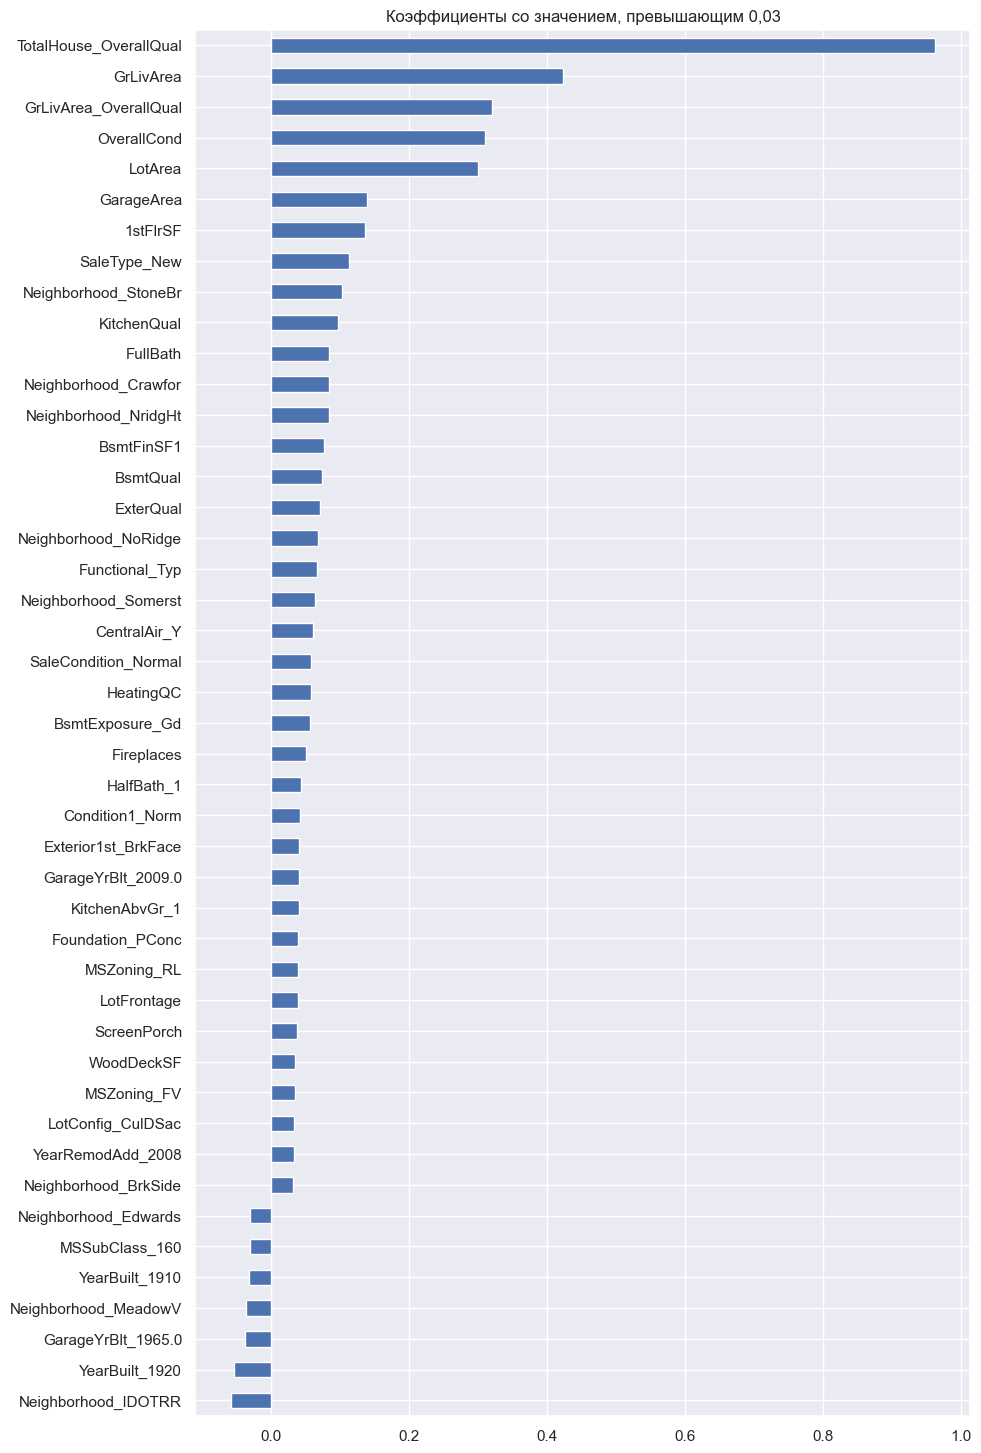

In [195]:
lasso = searchCV.best_estimator_
coefs = pd.Series(lasso.coef_,index=X.columns)

plt.figure(figsize=(10,18))
coefs[coefs.abs()>0.03].sort_values().plot.barh()
plt.title('Коэффициенты со значением, превышающим 0,03')

In [198]:
missing= X_test[X_test.isnull().any(axis=1)].index #bool операция по нахождению пропущенных значений в строках
print(missing) # Если строк 0, то пропущенных значений точно нет, всем можно идти домой


Int64Index([], dtype='int64', name='Id')


In [200]:
#Посмотрим ответ для тестовых параметров!
y_test_pred = searchCV.predict(X_test)
y_test_pred = np.exp(y_test_pred)
my_submission = pd.DataFrame({'Id': X_test.index.astype(int), 'SalePrice': y_test_pred})
print(my_submission)
my_submission.to_csv('submission.csv', index=False)

        Id      SalePrice
0     1461  116631.450046
1     1462  167103.748372
2     1463  182676.494399
3     1464  200701.236445
4     1465  197406.370198
...    ...            ...
1454  2915   85903.266571
1455  2916   83730.469688
1456  2917  165149.288583
1457  2918  119275.634344
1458  2919  214824.037120

[1459 rows x 2 columns]


In [319]:
print('Ура! Всё получилось! отдельным файлом выводим готовые значения для всей test номеров.\nНу и давайте проверим, сколько же будет стоить идеальный для меня домик))')
# num=df_test[df_test['OverallCond']==9][df_test['OverallQual']==8][df_test['HeatingQC']=='Ex']['2ndFlrSF']
# print(num)
# num=df_test.loc[[1539]]
num=df_test[df_test.index==1539]
num
for name  in num:
    print(f"{name} : {num[name].values[0]}")



Ура! Всё получилось! отдельным файлом выводим готовые значения для всей test номеров.
Ну и давайте проверим, сколько же будет стоить идеальный для меня домик))
MSSubClass : 70
MSZoning : RM
LotFrontage : 50.0
LotArea : 9000
Street : Pave
Alley : Grvl
LotShape : Reg
LandContour : Lvl
Utilities : AllPub
LotConfig : Inside
LandSlope : Gtl
Neighborhood : OldTown
Condition1 : Norm
Condition2 : Norm
BldgType : 1Fam
HouseStyle : 2Story
OverallQual : 8
OverallCond : 9
YearBuilt : 1890
YearRemodAdd : 2002
RoofStyle : Gable
RoofMatl : CompShg
Exterior1st : Wd Sdng
Exterior2nd : Wd Sdng
MasVnrType : None
MasVnrArea : 0.0
ExterQual : Gd
ExterCond : Gd
Foundation : Stone
BsmtQual : Fa
BsmtCond : Fa
BsmtExposure : No
BsmtFinType1 : Unf
BsmtFinSF1 : 0.0
BsmtFinType2 : Unf
BsmtFinSF2 : 0.0
BsmtUnfSF : 346.0
TotalBsmtSF : 346.0
Heating : GasA
HeatingQC : Ex
CentralAir : Y
Electrical : SBrkr
1stFlrSF : 1157
2ndFlrSF : 1111
LowQualFinSF : 0
GrLivArea : 2268
BsmtFullBath : 0.0
BsmtHalfBath : 0.0
FullBath 

Выберем, к примеру, id 1539, где общее кол-во комнат (TotRmsAbvGrd) аж целых 7!
Тк этот Id уже есть в test данных, давайте просто попросим машину для этого Id всё и проделать.

Пусть машина попробует оценить стоимость такого дома)

In [325]:
num=X_test[X_test.index==1539]
# print(num)
y_test_pred = searchCV.predict(num)
y_test_pred = np.exp(y_test_pred)
print(f"Дом с индексом 1539 стоит :{y_test_pred[0].round(0)}$")

Дом с индексом 1539 стоит :187630.0$


В целом, результат очень даже хороший! К примеру, у этого датасета есть соревнование, кто круче построит модель, которая будет ближе описывать реальную стоимость тестовых домов. Так вот, у одного чувака, занимающего лидирующую позицию в соревновании, этот же дом стоит 179045$, что очень и очень близко к нашему значению. Это круто!

Ну что ж, на этом я думаю можно заканчивать, было приятно делать этот проект, хотя я в любом случае делал его не совсем самостоятельно, но многие вещи всё равно по итогу были мною переделаю, чтобы немного оптимизировать работу. Всем спасибо за прочтение! Хоть я и так знаю, что это никто и не читает.